In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import json
import torch
import joblib
import numpy as np
from types import SimpleNamespace
from torch.nn import functional as F
from scripts import launch_pretraining, launch_finetuning

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import clear_output
from scipy.special import xlogy
from utils import load_stats
from model import *
from dataset import *

from matplotlib.colors import LogNorm, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
if not os.path.isdir('final-images'):
    os.mkdir('final-images')

## Data visualization

In [4]:
X_train, X_test, y_train, y_test = torch.load(f'experiments-final/f_all=tick/PT-FCN-seed=101/data.pt')[:4]

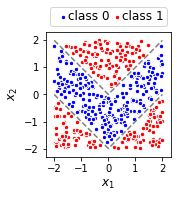

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
plt.tight_layout()
delta = 2.3

ax.scatter(X_train[y_train == 0, 4], X_train[y_train == 0, 5],
            color='blue', edgecolor='white', s=20, alpha=1, label='class 0')
ax.scatter(X_train[y_train == 1, 4], X_train[y_train == 1, 5],
            color='red', edgecolor='white', s=20, alpha=1, label='class 1')

xs = np.linspace(-2, 2, 1000)
ax.plot(xs, np.abs(xs), color='gray', linestyle='--')
ax.plot(xs, np.abs(xs) - 2, color='gray', linestyle='--')
ax.set_xlim((-delta, delta))
ax.set_ylim((-delta, delta))
ax.set_xlabel(f'$x_1$', fontsize=12)
ax.set_ylabel(f'$x_2$', fontsize=12)
ax.set_xticks([-2, -1, 0, 1, 2])
ax.set_yticks([-2, -1, 0, 1, 2])
plt.gca().set_aspect('equal')
plt.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.25),
           handletextpad=-0.35, columnspacing=-0.2, borderpad=0.25, handlelength=1.6, fontsize=12)
plt.savefig('final-images/samples.pdf', bbox_inches='tight')

## Fine-tuning and SWA accuracy

In [6]:
dirs = sorted(glob.glob('experiments-final/f_all=tick/PT-*'))
configs = []
for dir_name in dirs:
    with open(os.path.join(dir_name, 'config.json')) as file:
        configs.append(SimpleNamespace(**json.load(file)))
configs = sorted(configs, key=lambda x: (x.data_seed, x.pt_seed))
lrs = configs[0].lrs

In [ ]:
pt_train_losses, pt_test_losses, pt_train_accs, pt_test_accs, \
    pt_stoch_grad_norms = load_stats(configs, pt=True, )
ft_train_losses, ft_test_losses, ft_train_accs, ft_test_accs, \
    ft_stoch_grad_norms = load_stats(configs, pt=False, num_ft_lrs=11)
swa_accs = joblib.load('experiments-final/f_all=tick/swa.pickle')

In [12]:
cols = sns.color_palette('gist_rainbow', 16)
cols_long = cols
sns.set_palette(sns.color_palette(cols_long))
cols_long = sns.color_palette(cols_long)

cols = sns.color_palette('gist_rainbow', 30)
cols = [cols[0], cols[4], cols[12], cols[18], cols[26]]
sns.set_palette(sns.color_palette(cols))
cols = sns.color_palette(cols)
cols

[(1.0, 0.007419183889772136, 0.0),
 (1.0, 0.706942236354001, 0.0),
 (0.0, 1.0, 0.1054185114906178),
 (0.0, 0.8599744245524292, 1.0),
 (0.546675191815857, 0.0, 1.0)]

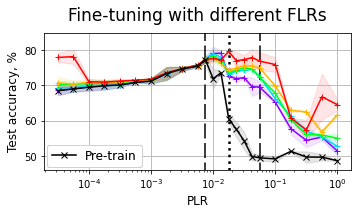

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6 / 1.2, 3 / 1.2))
plt.tight_layout()

r1, r2, rm = 10, 17, 14
rg = [0, 2, 4, 6, 8]
rg = [0, 3, 6, 8, 10]
colors = cols[::-1]
train_loss_align = None

ax.axvline(lrs[r1], color='black', linestyle=(5, (10, 3)))
ax.axvline(lrs[r2], color='black', linestyle=(5, (10, 3)))
ax.axvline(lrs[rm - 1], color='black', linestyle=':', linewidth=2.5)

for num_j, j in enumerate(rg):
    if train_loss_align is not None:
        indices = np.abs(ft_train_losses[:, :, j] - train_loss_align).argmin(axis=-1)
        n_lrs = indices.shape[1]
        m = np.stack(
            [ft_test_accs[[i] * n_lrs, range(n_lrs), [j] * n_lrs, indices[i]]
                for i in range(indices.shape[0])], axis=0
        )
    else:
        m = ft_test_accs[..., j, -1:].mean(-1)
    ax.plot(lrs, 100 * m.mean(0), color=colors[num_j], marker='+', label=f'{lrs[j]:.1e}', alpha=1)
    ax.fill_between(lrs, 100 * (m.mean(0) - m.std(0)), 100 * (m.mean(0) + m.std(0)), color=colors[num_j], alpha=0.1)

m = pt_test_accs[..., -1:].mean(-1)
ax.plot(lrs, 100 * m.mean(0), color='black',
        marker='x', label='Pre-train')
ax.fill_between(lrs, 100 * (m.mean(0) - m.std(0)), 100 * (m.mean(0) + m.std(0)), color='black', alpha=0.1)

ax.set_xscale('log')

ax.grid()
ax.set_xlabel('PLR', fontsize=12)
ax.set_ylabel('Test accuracy, %', fontsize=12)
ax.set_title('Fine-tuning with different FLRs', fontsize=17, pad=12)
ax.set_ylim((46, 85))

handles, labels = ax.get_legend_handles_labels()
labels = ['Pre-train'] + [f'{lr:.1e}'.replace('e-0', 'e-') for lr in np.array(lrs)[rg[::-1]]]
legend = ax.legend(handles[:-1][::-1], labels[1:],loc=(1.03,0.1),fontsize=12,title='FLR')
legend_stars = ax.legend([handles[-1]], [labels[0]],loc=(0.01,0.02),fontsize=12)
legend.get_title().set_fontsize('12')
ax.add_artist(legend)
ax.add_artist(legend_stars)

plt.savefig('final-images/f_all=tick-ft_test_acc.pdf', bbox_extra_artists=(legend,), bbox_inches='tight')

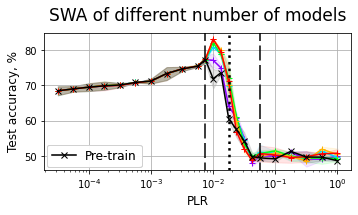

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6 / 1.2, 3 / 1.2))
plt.tight_layout()

r1, r2, rm = 10, 17, 14
rg = [2, 5, 10, 20, 50]
colors = cols[::-1]
train_loss_align = None

for num_j, j in enumerate(rg):
    m = swa_accs[..., num_j]
    ax.plot(lrs, m.mean(0), color=colors[num_j], marker='+', label=f'{j}', alpha=1)
    ax.fill_between(lrs, m.mean(0) - m.std(0), m.mean(0) + m.std(0), color=colors[num_j], alpha=0.1)

m = pt_test_accs[..., -1:].mean(-1)
ax.plot(lrs, 100 * m.mean(0), color='black',
        marker='x', label='Pre-train')
ax.fill_between(lrs, 100 * (m.mean(0) - m.std(0)), 100 * (m.mean(0) + m.std(0)), color='black', alpha=0.1)

ax.set_xscale('log')
ax.axvline(lrs[r1], color='black', linestyle=(5, (10, 3)))
ax.axvline(lrs[r2], color='black', linestyle=(5, (10, 3)))
ax.axvline(lrs[rm - 1], color='black', linestyle=':', linewidth=2.5)

ax.grid()
ax.set_xlabel('PLR', fontsize=12)
ax.set_ylabel('Test accuracy, %', fontsize=12)
ax.set_title('SWA of different number of models', fontsize=17, pad=12)
ax.set_ylim((46, 85))

handles, labels = ax.get_legend_handles_labels()
labels = ['Pre-train'] + rg[::-1]
legend = ax.legend(handles[:-1][::-1], labels[1:],loc=(1.03,0.1),fontsize=12,title='Models')
legend_stars = ax.legend([handles[-1]], [labels[0]],loc=(0.01,0.02),fontsize=12)
legend.get_title().set_fontsize('12')
ax.add_artist(legend)
ax.add_artist(legend_stars)

plt.savefig('final-images/f_all=tick-swa_test_acc.pdf', bbox_extra_artists=(legend,), bbox_inches='tight')

## Feature importance

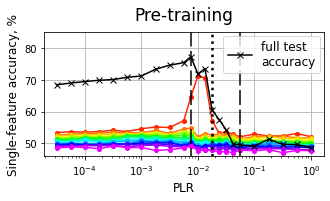

In [15]:
group_accs = joblib.load('experiments-final/f_all=tick/pt_group_accs.pickle')
accs = np.sort(group_accs, axis=-1)[..., ::-1]

fig, ax = plt.subplots(1, 1, figsize=(6 / 1.3, 3 / 1.3))
plt.tight_layout()

r1, r2, rm = 10, 17, 14
colors = cols_long

for j in range(16):
    m = accs[..., j]
    ax.plot(lrs, 100 * m.mean(0), color=colors[j], marker='o', alpha=1, markersize=4)

m = pt_test_accs[..., -1:].mean(-1)
ax.plot(lrs, 100 * m.mean(0), color='black',
            marker='x', label='full test\naccuracy')

ax.set_xscale('log')
ax.axvline(lrs[r1], color='black', linestyle=(5, (10, 3)))
ax.axvline(lrs[r2], color='black', linestyle=(5, (10, 3)))
ax.axvline(lrs[rm - 1], color='black', linestyle=':', linewidth=2.5)

ax.grid()
ax.set_xlabel('PLR', fontsize=12)
ax.set_ylabel('Single-feature accuracy, %', fontsize=12)
ax.set_title('Pre-training', fontsize=17, pad=12)
ax.set_ylim((46, 85))

ax.legend(loc=(0.64, 0.67), fontsize=12)
plt.savefig('final-images/f_all=tick-pt_group_acc.pdf', bbox_inches='tight')

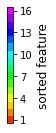

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(1, 3 / 1.4))
plt.gca().set_visible(False)
cmap = LinearSegmentedColormap.from_list('rainbow-2', list(colors), N=len(colors))
sm = ScalarMappable(cmap=cmap)
cbar = plt.colorbar(sm, ticks=1/32 + np.linspace(0, 1, 17)[:16][::3], ax=ax)
cbar.ax.set_yticklabels(range(1, 17, 3))
cbar.set_label('sorted feature', fontsize=12)
plt.savefig('final-images/f_all=tick-group_acc-cbar.pdf', bbox_inches='tight')

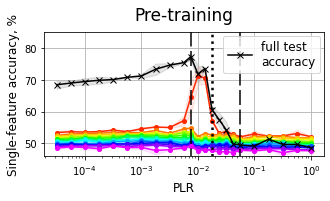

In [17]:
group_accs = joblib.load('experiments-final/f_all=tick/pt_group_accs.pickle')
accs = np.sort(group_accs, axis=-1)[..., ::-1]

fig, ax = plt.subplots(1, 1, figsize=(6 / 1.3, 3 / 1.3))
plt.tight_layout()

r1, r2, rm = 10, 17, 14
colors = cols_long

for j in range(16):
    m = accs[..., j]
    ax.plot(lrs, 100 * m.mean(0), color=colors[j], marker='o', alpha=1, markersize=4)
    ax.fill_between(lrs, 100 * (m.mean(0) - m.std(0)), 100 * (m.mean(0) + m.std(0)), color=colors[j], alpha=0.1)

m = pt_test_accs[..., -1:].mean(-1)
ax.plot(lrs, 100 * m.mean(0), color='black',
        marker='x', label='full test\naccuracy')
ax.fill_between(lrs, 100 * (m.mean(0) - m.std(0)), 100 * (m.mean(0) + m.std(0)), color='black', alpha=0.1)

ax.set_xscale('log')
ax.axvline(lrs[r1], color='black', linestyle=(5, (10, 3)))
ax.axvline(lrs[r2], color='black', linestyle=(5, (10, 3)))
ax.axvline(lrs[rm - 1], color='black', linestyle=':', linewidth=2.5)

ax.grid()
ax.set_xlabel('PLR', fontsize=12)
ax.set_ylabel('Single-feature accuracy, %', fontsize=12)
ax.set_title('Pre-training', fontsize=17, pad=12)
ax.set_ylim((46, 85))

ax.legend(loc=(0.64, 0.67), fontsize=12)
plt.savefig('final-images/f_all=tick-pt_group_acc-app.pdf', bbox_inches='tight')

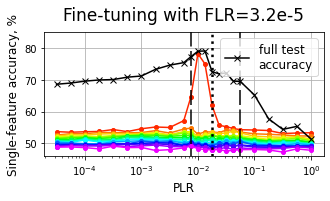

In [18]:
group_accs = joblib.load(f'experiments-final/f_all=tick/ft_group_accs-flr={lrs[0]:.3e}.pickle')
accs = np.sort(group_accs, axis=-1)[..., ::-1]

fig, ax = plt.subplots(1, 1, figsize=(6 / 1.3, 3 / 1.3))
plt.tight_layout()

r1, r2, rm = 10, 17, 14
colors = cols_long

for j in range(16):
    m = accs[..., j]
    ax.plot(lrs, 100 * m.mean(0), color=colors[j], marker='o', alpha=1, markersize=4)
    #ax.fill_between(lrs, m.mean(0) - m.std(0), m.mean(0) + m.std(0), color=colors[num_j], alpha=0.25)

m = ft_test_accs[..., 0, -1:].mean(-1)
ax.plot(lrs, 100 * m.mean(0), color='black',
            marker='x', label='full test\naccuracy')

ax.set_xscale('log')
ax.axvline(lrs[r1], color='black', linestyle=(5, (10, 3)))
ax.axvline(lrs[r2], color='black', linestyle=(5, (10, 3)))
ax.axvline(lrs[rm - 1], color='black', linestyle=':', linewidth=2.5)

ax.grid()
ax.set_xlabel('PLR', fontsize=12)
ax.set_ylabel('Single-feature accuracy, %', fontsize=12)
ax.set_title('Fine-tuning with FLR=3.2e-5', fontsize=17, pad=12)
ax.set_ylim((46, 85))

ax.legend(loc='upper right', fontsize=12)
plt.savefig('final-images/f_all=tick-ft_group_acc-flr=3.2e-5.pdf', bbox_inches='tight')

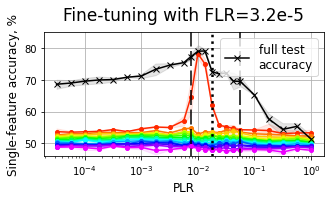

In [19]:
group_accs = joblib.load(f'experiments-final/f_all=tick/ft_group_accs-flr={lrs[0]:.3e}.pickle')
accs = np.sort(group_accs, axis=-1)[..., ::-1]

fig, ax = plt.subplots(1, 1, figsize=(6 / 1.3, 3 / 1.3))
plt.tight_layout()

r1, r2, rm = 10, 17, 14
colors = cols_long

for j in range(16):
    m = accs[..., j]
    ax.plot(lrs, 100 * m.mean(0), color=colors[j], marker='o', alpha=1, markersize=4)
    ax.fill_between(lrs, 100 * (m.mean(0) - m.std(0)), 100 * (m.mean(0) + m.std(0)), color=colors[j], alpha=0.1)

m = ft_test_accs[..., 0, -1:].mean(-1)
ax.plot(lrs, 100 * m.mean(0), color='black',
            marker='x', label='full test\naccuracy')
ax.fill_between(lrs, 100 * (m.mean(0) - m.std(0)), 100 * (m.mean(0) + m.std(0)), color='black', alpha=0.1)

ax.set_xscale('log')
ax.axvline(lrs[r1], color='black', linestyle=(5, (10, 3)))
ax.axvline(lrs[r2], color='black', linestyle=(5, (10, 3)))
ax.axvline(lrs[rm - 1], color='black', linestyle=':', linewidth=2.5)

ax.grid()
ax.set_xlabel('PLR', fontsize=12)
ax.set_ylabel('Single-feature accuracy, %', fontsize=12)
ax.set_title('Fine-tuning with FLR=3.2e-5', fontsize=17, pad=12)
ax.set_ylim((46, 85))

ax.legend(loc='upper right', fontsize=12)
plt.savefig('final-images/f_all=tick-ft_group_acc-flr=3.2e-5-app.pdf', bbox_inches='tight')

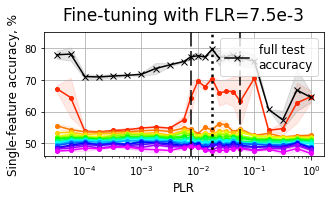

In [20]:
group_accs = joblib.load(f'experiments-final/f_all=tick/ft_group_accs-flr={lrs[10]:.3e}.pickle')
accs = np.sort(group_accs, axis=-1)[..., ::-1]

fig, ax = plt.subplots(1, 1, figsize=(6 / 1.3, 3 / 1.3))
plt.tight_layout()

r1, r2, rm = 10, 17, 14
colors = cols_long

for j in range(16):
    m = accs[..., j]
    ax.plot(lrs, 100 * m.mean(0), color=colors[j], marker='o', alpha=1, markersize=4)
    ax.fill_between(lrs, 100 * (m.mean(0) - m.std(0)), 100 * (m.mean(0) + m.std(0)), color=colors[j], alpha=0.1)

m = ft_test_accs[..., 10, -1:].mean(-1)
ax.plot(lrs, 100 * m.mean(0), color='black',
            marker='x', label='full test\naccuracy')
ax.fill_between(lrs, 100 * (m.mean(0) - m.std(0)), 100 * (m.mean(0) + m.std(0)), color='black', alpha=0.1)

ax.set_xscale('log')
ax.axvline(lrs[r1], color='black', linestyle=(5, (10, 3)))
ax.axvline(lrs[r2], color='black', linestyle=(5, (10, 3)))
ax.axvline(lrs[rm - 1], color='black', linestyle=':', linewidth=2.5)

ax.grid()
ax.set_xlabel('PLR', fontsize=12)
ax.set_ylabel('Single-feature accuracy, %', fontsize=12)
ax.set_title('Fine-tuning with FLR=7.5e-3', fontsize=17, pad=12)
ax.set_ylim((46, 85))

ax.legend(loc='upper right', fontsize=12)
plt.savefig('final-images/f_all=tick-ft_group_acc-flr=7.5e-3.pdf', bbox_inches='tight')

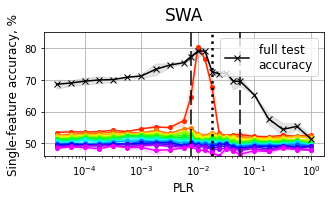

In [21]:
group_accs = joblib.load('experiments-final/f_all=tick/swa_group_accs.pickle')
accs = np.sort(group_accs, axis=-1)[..., ::-1]

fig, ax = plt.subplots(1, 1, figsize=(6 / 1.3, 3 / 1.3))
plt.tight_layout()

r1, r2, rm = 10, 17, 14
colors = cols_long

for j in range(16):
    m = accs[..., j]
    ax.plot(lrs, 100 * m.mean(0), color=colors[j], marker='o', alpha=1, markersize=4)
    ax.fill_between(lrs, 100 * (m.mean(0) - m.std(0)), 100 * (m.mean(0) + m.std(0)), color=colors[j], alpha=0.1)

m = ft_test_accs[..., 0, -1:].mean(-1)
ax.plot(lrs, 100 * m.mean(0), color='black',
            marker='x', label='full test\naccuracy')
ax.fill_between(lrs, 100 * (m.mean(0) - m.std(0)), 100 * (m.mean(0) + m.std(0)), color='black', alpha=0.1)

ax.set_xscale('log')
ax.axvline(lrs[r1], color='black', linestyle=(5, (10, 3)))
ax.axvline(lrs[r2], color='black', linestyle=(5, (10, 3)))
ax.axvline(lrs[rm - 1], color='black', linestyle=':', linewidth=2.5)

ax.grid()
ax.set_xlabel('PLR', fontsize=12)
ax.set_ylabel('Single-feature accuracy, %', fontsize=12)
ax.set_title('SWA', fontsize=17, pad=12)
ax.set_ylim((46, 85))

ax.legend(loc='upper right', fontsize=12)
plt.savefig('final-images/f_all=tick-swa_group_acc.pdf', bbox_inches='tight')

## Angular distance and error barriers

In [22]:
angles, train_barriers, train_errors, test_barriers, test_errors = \
    joblib.load(f'experiments-final/f_all=tick/barriers-low_flr={lrs[0]:.3e}-high_flr={lrs[10]:.3e}.pickle')

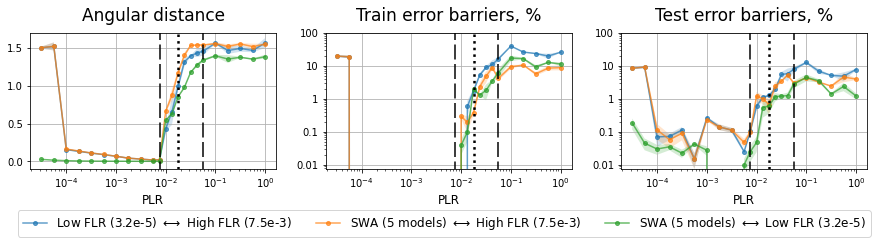

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(6 * 3 / 1.2, 3 / 1.2))
sns.set_palette("tab10")

r1, r2, rm = 10, 17, 14
flr1, flr2 = lrs[0], lrs[10]
labels = [
    f'Low FLR ({flr1:.1e}) $\longleftrightarrow$ High FLR ({flr2:.1e})'.replace('e-0', 'e-'),
    f'SWA (5 models) $\longleftrightarrow$ High FLR ({flr2:.1e})'.replace('e-0', 'e-'),
    f'SWA (5 models) $\longleftrightarrow$ Low FLR ({flr1:.1e})'.replace('e-0', 'e-')
]

for i in range(3):
    m, s = angles[i].mean(0), angles[i].std(0)
    axs[0].plot(lrs, m, marker='o', alpha=0.7, label=labels[i], markersize=4)
    axs[0].fill_between(lrs, m - s, m + s, alpha=0.2)

    m = train_barriers[i]
    axs[1].plot(lrs, np.median(m, axis=0), marker='o', alpha=0.7, label=labels[i], markersize=4)
    axs[1].fill_between(lrs, np.quantile(m, 0.25, axis=0), np.quantile(m, 0.75, axis=0), alpha=0.2)

    m = test_barriers[i]
    axs[2].plot(lrs, np.median(m, axis=0), marker='o', alpha=0.7, label=labels[i], markersize=4)
    axs[2].fill_between(lrs, np.quantile(m, 0.25, axis=0), np.quantile(m, 0.75, axis=0), alpha=0.2)

for ax in axs:
    ax.set_xscale('log')
    ax.grid()
    ax.set_xlabel('PLR', fontsize=12)
    ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1])
    ax.axvline(lrs[r1], color='black', linestyle=(5, (10, 3)))
    ax.axvline(lrs[r2], color='black', linestyle=(5, (10, 3)))
    ax.axvline(lrs[rm - 1], color='black', linestyle=':', linewidth=2.5)

axs[0].set_ylim((-0.1, 1.7))
for ax in axs[1:]:
    ax.set_yscale('log')
    ax.set_ylim((7.5e-3, 100))
    ax.set_yticks([0.01, 0.1, 1, 10, 100], ['0.01', '0.1', '1', '10', '100'])

axs[0].set_title('Angular distance', fontsize=17, pad=12)
axs[1].set_title('Train error barriers, %', fontsize=17, pad=12)
axs[2].set_title('Test error barriers, %', fontsize=17, pad=12)
axs[0].legend(loc=(-0.05,-0.5), ncol=3, fontsize=12)
plt.subplots_adjust(wspace=0.2)
plt.savefig('final-images/f_all=tick-barriers.pdf', bbox_inches='tight')